# Example how to query multiple items using paging

In [1]:
import sys
from sgqlc.operation import Operation
from pdp_schema import pdp_schema as schema
from pdp_graphql_client_python import client

In [2]:
# fetch environment variable with PDP endpoint API address
! echo "${PDP_API}"

https://graphql-api.pdp.int.srgssr.ch/graphql


In [3]:
# show available queries
schema.Query

type Query {
  faroProgramPage(first: Int!, after: String): FaroProgramPage!
  faroPrograms(ids: [String!]!): [FaroProgram]!
  randomFaroPrograms: [FaroProgram!]!
  faroItemPage(first: Int!, after: String): FaroItemPage!
  faroItems(ids: [String!]!): [FaroItem]!
  faroItemsByPlayUrn(urns: [String!]!): [FaroItem]!
  faroItemsByPlayUrnGraphDb(urns: [String!]!): [FaroItem]!
  randomFaroItems: [FaroItem!]!
}

In [18]:
# retrieve query operations
op = Operation(schema.Query)

In [19]:
type(op)

sgqlc.operation.Operation

In [20]:
# return current query (empty)
op

query {
}

In [21]:
# select random faro item query (underscore)
faro = op.random_faro_items()

In [22]:
# return current query (empty)
op

query {
  randomFaroItems {
    id
    programId
    itemNr
    rights
    isPoisonous
    playMedias {
      id
      title
      urn
      description
    }
    mediaUrns
    playLinks
    descriptorPaths
    program {
      id
      bu
      mediaType
      episodeIds
      sTit
      sDatStart
      sGef
      pTit
      department
      workgroup
      seriesNr
    }
    bTit
    recordingDate
    ingestDate
    prodTypes
    producer
    licenseHolder
    abs
    fdes
    sportDoc {
      season
      sportEventPaths
      sportPaths
    }
    webCmsIds
  }
}

In [10]:
# return current query
op

query PagingQuery($first: Int!, $after: String) {
  faroProgramPage(first: $first, after: $after) {
    edges {
      id
      mediaType
      sDatStart
      sGef
      sTit
      seriesNr
    }
    cursor
  }
}

In [31]:
# constants
page_requests = 100

In [32]:
# init results
results = []

In [34]:
# download data
from tqdm.notebook import tnrange
for i in tnrange(page_requests, desc="Downloading data"):
    # query page
    data = client.run_query(op)
    
    # add results
    results += (op + data).random_faro_items

In [35]:
print(f'INFO - Retrieved {len(results):,} FaroItems')

INFO - Retrieved 1,000 FaroItems


## plot year distribution of retrieved data

In [37]:
results[0].program.s_dat_start

'2020-07-22'

In [38]:
from collections import Counter
from datetime import date

# count year occurrences
c = Counter(date.fromisoformat(x.program.s_dat_start).year for x in results if x.program.s_dat_start)

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

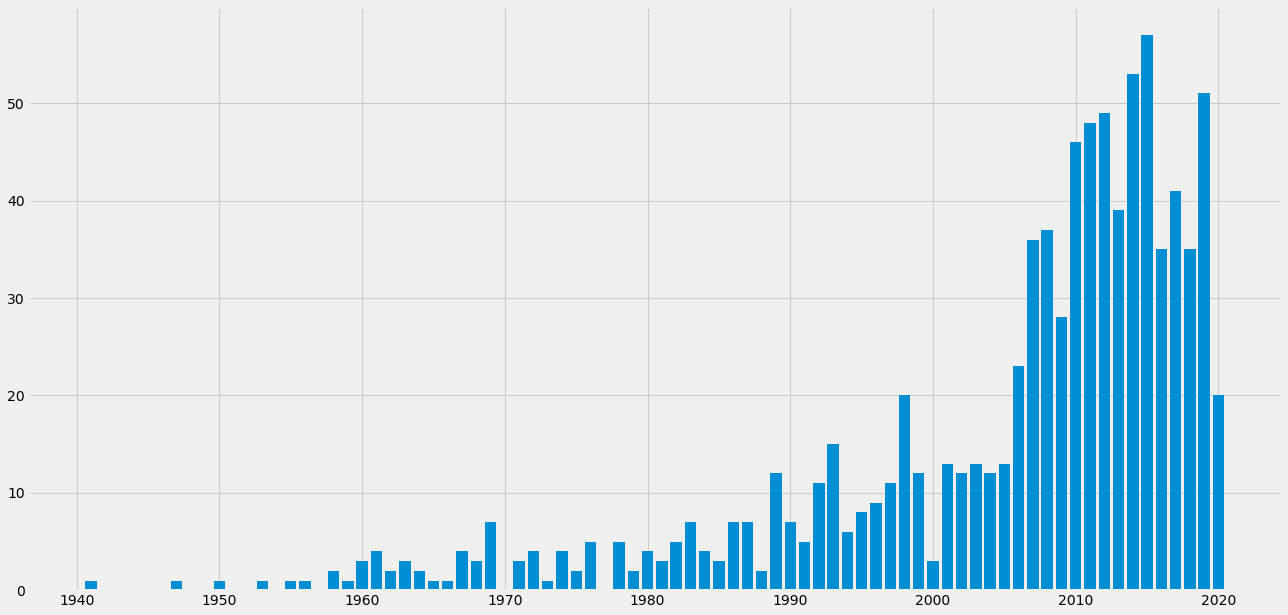

In [40]:
with plt.style.context('fivethirtyeight'):
    plt.bar(c.keys(), c.values())

## load data into pandas

In [41]:
import pandas as pd

In [43]:
results[0].__fields_cache__

OrderedDict([('id', id: String!),
             ('program_id', programId: String!),
             ('item_nr', itemNr: Int!),
             ('rights', rights: String!),
             ('is_poisonous', isPoisonous: Boolean!),
             ('play_medias', playMedias: [PlayMedia!]!),
             ('media_urns', mediaUrns: [String!]!),
             ('play_links', playLinks: [String!]!),
             ('descriptor_paths', descriptorPaths: [String!]!),
             ('program', program: FaroProgram),
             ('b_tit', bTit: String),
             ('recording_date', recordingDate: String),
             ('ingest_date', ingestDate: String),
             ('prod_types', prodTypes: [String!]!),
             ('producer', producer: String),
             ('license_holder', licenseHolder: String),
             ('abs', abs: String),
             ('fdes', fdes: String),
             ('sport_doc', sportDoc: FaroSportDoc!),
             ('web_cms_ids', webCmsIds: [String!]!)])

In [73]:
# todo: find better way to import data into pandas
df = pd.DataFrame([x.__json_data__ for x in results])

In [74]:
df

,program,mediaUrns,fdes,bTit,ingestDate,isPoisonous,descriptorPaths,itemNr,rights,prodTypes,playLinks,sportDoc,recordingDate,id,webCmsIds,programId,abs,licenseHolder,producer,playMedias
0,"{'sGef': 'Tagesschau Hauptausgabe (TS)', 'sTit...",[],None,Grenzüberscheitendes Homeoffice,None,False,"[¦ARBEIT.¦ARBEIT¦, ¦ARBEIT.¦ARBEIT¦, ¦STAAT.¦S...",1,"Rechte bei SRF/SRG, Rechte bei SRF/SRG",[Eigenproduktion UE],[],"{'season': None, 'sportEventPaths': [], 'sport...",None,55749c35-01af-4195-98a9-c2a55a89ed25,[8849de68-38c5-4c53-b17b-b94ea022c098],97b61887-88fe-47d5-ac8f-f8789bc62e99,"Schweiz <Genève, GE: Wenn Grenzgängerinnen und...",SRF,SRF,[]
1,"{'sGef': None, 'sTit': None, 'mediaType': 'aud...",[],None,SRF Musikwelle 17.02.2008 07 - 08 Uhr,None,False,[],0,,[],[],"{'season': None, 'sportEventPaths': [], 'sport...",None,55749f7f-3a50-4252-8481-4e6630884ba1,[],378c3451-1297-4f70-9b47-08a5f75d5fea,None,None,None,[]
2,"{'sGef': None, 'sTit': None, 'mediaType': 'aud...",[],None,Regionaljournal GR 25.05.2014,None,False,[],0,,[],[],"{'season': None, 'sportEventPaths': [], 'sport...",None,5574a675-28b6-4eb1-b11d-f6c78b7c1ee5,[],64c7e414-6790-4ba3-936b-623a8f0b1d25,None,None,None,[]
3,"{'sGef': 'Schreckmümpfeli', 'sTit': None, 'med...",[urn:srf:audio:66195ff2-eb67-440e-a05a-6a3c421...,[Aufnahmeort]: Bern,"Der Posten [Version 2012, aufbereitet]",None,False,"[¦POLITIK.¦KRIEG¦, ¦VERKEHR.¦RAUMFAHRT¦, ¦KULT...",0,Rechte nicht bekannt,[Eigenproduktion UE],[http://srf.ch/play/radio/redirect/detail/6619...,"{'season': None, 'sportEventPaths': [], 'sport...",None,5574aaea-4012-4f92-95dc-dd98e4513372,[],554da0b7-00af-451d-a713-9dcea6f8a03e,Inhalt:\r\nBei der intergalaktischen Eroberung...,None,None,[]
4,"{'sGef': 'EVN/News-Agenturmaterial', 'sTit': N...",[],None,None,None,False,[¦POLITIK.¦UNRUHEN¦],7,freie Verwendung SRG-intern,[Einkauf],[],"{'season': None, 'sportEventPaths': [], 'sport...",None,5574b79e-fdcb-4ac6-affa-fed80a5f2b14,[],d78d9561-d04d-4395-911d-992c7ac02e61,"Jugoslawien <Dubrovnik, Kroatien: Attacken der...",None,EVN/JRT,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"{'sGef': None, 'sTit': None, 'mediaType': 'aud...",[],None,Regionaljournal BS\/BL 21.03.2007 12:00 Uhr,None,False,[],0,,[],[],"{'season': None, 'sportEventPaths': [], 'sport...",None,e0161736-8079-45db-8659-f36bbf66b106,[],ee244261-36e5-4abe-9784-29290f203e63,None,None,None,[]
996,"{'sGef': None, 'sTit': None, 'mediaType': 'vid...",[],None,None,None,False,[¦WIRTSCHAFT.¦WÄHRUNG¦EWS¦],0,freie Verwendung SRG-intern,[Einkauf],[],"{'season': None, 'sportEventPaths': [], 'sport...",None,e0162052-b683-4584-a34f-3cff057f5d3e,[],fa5c1aab-2ebc-484c-a980-f897805483ac,Belgien <Brüssel: PKs des Euro-Gipfels zur Sch...,None,EVN/CEE,[]
997,"{'sGef': 'Kassensturz (KS)', 'sTit': None, 'me...",[urn:srf:video:36f9d9ec-9362-413c-ba79-05ae7d6...,None,Etiketten-Schwindel 2019 (1\/2),None,False,[¦WIRTSCHAFT.¦KONSUMENT¦KONSUMENTENSCHUTZ¦],1,Rechte bei SRF/SRG,[Eigenproduktion UE],[http://srf.ch/play/tv/redirect/detail/36f9d9e...,"{'season': None, 'sportEventPaths': [], 'sport...",None,e016205d-c8f4-4b7e-b171-bd58518a1236,[36f9d9ec-9362-413c-ba79-05ae7d67c4ed],edf6998b-1580-49c0-8cb8-9efca183fb90,"Schweiz <TVZH: Abstimmung über \""Sieger\""-Prod...",SRF,SRF,[]
998,"{'sGef': None, 'sTit': None, 'mediaType': 'aud...",[],None,SRF 1 16.05.2015 09 - 10 Uhr,None,False,[],0,,[],[],"{'season': None, 'sportEventPaths': [], 'sport...",None,e01626b7-a40d-4a58-8f57-a45e9b759eb7,[],cc0c3783-5420-42da-b4f6-b2bfa958cba9,None,None,None,[]


## filter out most important producers and plot as pie chart

In [75]:
df.producer.describe()

count     485
unique     86
top       DRS
freq      132
Name: producer, dtype: object

<AxesSubplot:ylabel='producer'>

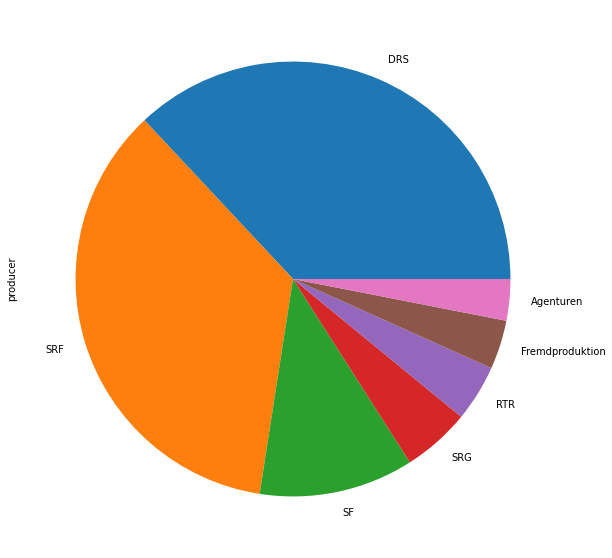

In [76]:
(df
 .groupby('producer')
 .filter(lambda x: len(x) > 10)
 .producer
 .value_counts()
 .plot
 .pie())

## filter out elements that contain the sportDoc entry

In [77]:
df2 = df.loc[pd.json_normalize(df.sportDoc).season.notna()]

In [78]:
df2

,program,mediaUrns,fdes,bTit,ingestDate,isPoisonous,descriptorPaths,itemNr,rights,prodTypes,playLinks,sportDoc,recordingDate,id,webCmsIds,programId,abs,licenseHolder,producer,playMedias
5,"{'sGef': 'Sport aktuell (Spak)', 'sTit': None,...",[urn:srf:video:208b1bb0-08a8-4fb6-bb23-5c3253f...,None,Schwimmen 100m int Weltmeisterschaft Final,None,False,[],3,Fremdrechte/ unklare Rechtesituation,[Eigenproduktion UE],[http://srf.ch/play/tv/redirect/detail/208b1bb...,"{'season': '2009', 'sportEventPaths': ['¦int¦W...",None,5574b7f3-84de-488f-9fd9-73f31cb19bf8,[208b1bb0-08a8-4fb6-bb23-5c3253f86d49],9923a854-1ce3-4c6a-925d-647c25a16644,Italien <Rom: Schwimmen Brustschwimmen 100m in...,unbekannt,SF,[]
57,"{'sGef': 'Sport aktuell (Spak)', 'sTit': None,...",[],None,Wassersport Segeln \/ Coutts wird Skipper und ...,None,False,[],7,Fremdrechte/ unklare Rechtesituation,[Eigenproduktion UE],[],"{'season': '2007', 'sportEventPaths': [], 'spo...",None,47fe97f5-68e1-4f7c-a84e-d2bfaab84820,[],d63e3c8e-751d-4443-b9f3-51342b59481d,o.O.: Wassersport Segeln 2007 Herren \/ Russe...,unbekannt,SF,[]
83,"{'sGef': 'Sportpanorama (Pano)', 'sTit': None,...",[urn:srf:video:87e5842a-c61d-4ed0-9a8b-f5a8344...,None,Turnen und Gymnastik Sprung int EM 1-3,None,False,[],2,Fremdrechte/ unklare Rechtesituation,[Eigenproduktion UE],[http://srf.ch/play/tv/redirect/detail/87e5842...,"{'season': '2012', 'sportEventPaths': ['¦int¦E...",None,f4be0332-cf34-4ef4-8167-4bca0df0dab2,[87e5842a-c61d-4ed0-9a8b-f5a834438f64],c0a8ab2e-623d-4f84-9ba2-bf783643bc8d,Belgien <Brüssel: Turnen und Gymnastik Kunsttu...,unbekannt,SRF,[]
88,"{'sGef': 'Sport aktuell (Spak)', 'sTit': None,...",[urn:srf:video:6d219954-e4cd-40b1-ba25-3106222...,None,Formel 1 GP Japan \/ Qualifying,None,False,[],5,Fremdrechte/ unklare Rechtesituation,[Eigenproduktion UE],[http://srf.ch/play/tv/redirect/detail/6d21995...,"{'season': '2016', 'sportEventPaths': ['¦int¦F...",None,f4be2413-f12f-432e-8593-992617363053,[6d219954-e4cd-40b1-ba25-31062229d09a],159e0607-aa47-4f97-9f89-0f16c240f671,Japan <Suzuka: Automobil Formel 1 int Formel 1...,unbekannt,SRF,[]
108,"{'sGef': 'Sport Live', 'sTit': None, 'mediaTyp...",[],None,Ski Alpin Riesenslalom int Weltcup \/ Sölden 1...,None,False,[],0,"Fremdrechte/ unklare Rechtesituation, Rechte b...",[Übernahme / Programmaustausch],[],"{'season': '2009-2010', 'sportEventPaths': ['¦...",None,f6eeb86a-57b3-49e6-be21-5fe646521128,[],cbce04f6-48a6-4d87-837d-2de845fa0a2a,Österreich <Sölden: Ski Alpin Riesenslalom int...,unbekannt;SF,ORF,[]
109,"{'sGef': 'Sport Live Programm', 'sTit': None, ...",[],None,Fussball Schweizermeisterschaft Sion - Lugano ...,None,False,[],13,Rechte bei SRF/SRG,[Eigenproduktion UE],[],"{'season': '2017-2018', 'sportEventPaths': ['¦...",None,f6eec140-ff33-4b78-aab6-ddbfa68327ac,[],77319669-4702-40ae-ac8a-37da0d034009,"Schweiz <Sion, VS: Fussball nat Schweizermeist...",SRF,SRF,[]
144,"{'sGef': 'Sport Live', 'sTit': None, 'mediaTyp...",[],None,Ski Alpin Slalom nat Adelboden Rennen int Welt...,None,False,[],0,Rechte bei SRF/SRG,[Eigenproduktion UE],[],"{'season': '2011-2012', 'sportEventPaths': ['¦...",None,a4c6e0eb-8da3-43c3-8e63-2f921cbd62c9,[],059d6a9a-a3ee-45e0-8c62-bba1b2b19ef5,"Schweiz, Adelboden, BE, Italien, Val di Fiemme...",SRF,SRF,[]
166,"{'sGef': 'Sport aktuell (Spak)', 'sTit': None,...",[],None,Tennis int Masters Round Robin Murray - Ferrer...,None,False,[],1,Fremdrechte/ unklare Rechtesituation,[Eigenproduktion UE],[],"{'season': '2010', 'sportEventPaths': ['¦int¦A...",None,b32706a2-93fc-44f4-96c2-afbcab7391fd,[],f8e78e04-add9-4345-aaba-586568a9dcfe,Grossbritannien <London: Tennis int Masters Ma...,unbekannt,SF,[]
181,"{'sGef': 'Sport Live Programm', 'sTit': None, ...",[],None,Fussball Champions League Vorrunde Arsenal - B...,None,False,[],6,"Fremdrechte/ unklare Rechtesituation, Rechte b...",[Eigenproduktion UE],[],"{'season': '2016-2017', 'sportEventPaths': ['¦...",None,b91b6e0f-2c06-4741-b51c-7bbee6879349,[],16f09e48-668b-4e39-b9eb-0902785a8baf,Grossbr